In [68]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from BaseModel import *
from LlamaModel import *
import torch
import matplotlib.pyplot as plt


In [69]:
#model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
#model_id = "facebook/opt-125m"
model_id = "openai/gpt-oss-20b"
#model_id = "mistralai/Mistral-7B-Instruct-v0.1"
llama = LlamaModel(model_id)
_ = llama.load(attn_implementation="eager")

MXFP4 quantization requires triton >= 3.4.0 and kernels installed, we will default to dequantizing the model to bf16

oading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]

In [70]:
print(llama.model)

GptOssForCausalLM(
  (model): GptOssModel(
    (embed_tokens): Embedding(201088, 2880, padding_idx=199999)
    (layers): ModuleList(
      (0-23): 24 x GptOssDecoderLayer(
        (self_attn): GptOssAttention(
          (q_proj): Linear(in_features=2880, out_features=4096, bias=True)
          (k_proj): Linear(in_features=2880, out_features=512, bias=True)
          (v_proj): Linear(in_features=2880, out_features=512, bias=True)
          (o_proj): Linear(in_features=4096, out_features=2880, bias=True)
        )
        (mlp): GptOssMLP(
          (router): GptOssTopKRouter()
          (experts): GptOssExperts()
        )
        (input_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
        (post_attention_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
      )
    )
    (norm): GptOssRMSNorm((2880,), eps=1e-05)
    (rotary_emb): GptOssRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2880, out_features=201088, bias=False)
)


In [86]:
def get_attention_values(model_class, prompt, max_tokens):
    tokenized_prompt = model_class.tokenizer(llama.format_prompt(prompt), return_tensors='pt')
    response = model_class.model.generate(**tokenized_prompt, max_new_tokens=max_tokens, do_sample=False, pad_token_id=model_class.tokenizer.eos_token_id)
    decoded_response = model_class.tokenizer.decode(response[0], skip_special_tokens=True)
    
    with torch.no_grad():
        attentions = model_class.model(response, output_attentions=True).attentions

    #attention_list = [ a.squeeze(dim=0).sum(dim=1) for a in attentions ]
    attention_list = [ a.squeeze(dim=0).sum(dim=0) for a in attentions ]
    print(attention_list[0].shape)
    
    return attention_list, decoded_response
    

torch.Size([130, 130])
systemYou are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-10-03

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.userWhen was Alan Turing born?assistantanalysisThe user asks: "When was Alan Turing born?" The answer: Alan Turing was born on 23 June 1912. Provide that.assistantfinalAlan Turing was born on **23 June 1912**.


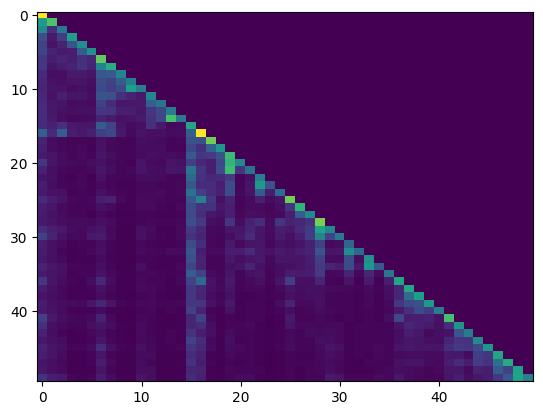

In [98]:
#prompt = " Tell me a story about a little girl named Mira in 50 words. Mira is a musician." 
#prompt = "What is the capital of USA?"
prompt = "When was Alan Turing born?"
#prompt = "What is the capital of France?"
attention_list, response = get_attention_values(llama, prompt, 1000)


print(response)
plt.imshow(attention_list[23][0:50, 0:50].to(torch.float32).numpy(), cmap='viridis', aspect='auto')
plt.show()

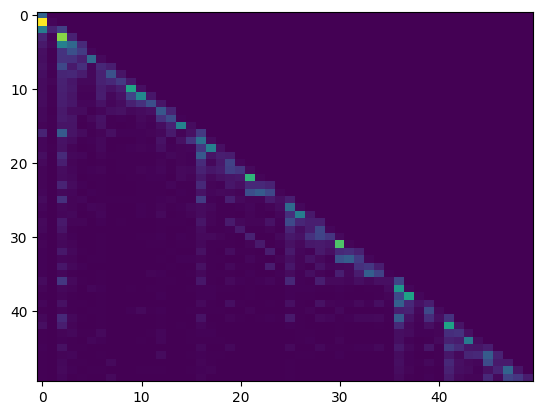

In [99]:
plt.imshow(attention_list[0][0:50, 0:50].to(torch.float32).numpy(), cmap='viridis', aspect='auto')
plt.show()